In [26]:
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
from PIL import Image
from scipy.stats import mannwhitneyu, kruskal
from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
import keras_tuner as kt
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation, Input, MaxPool2D, concatenate, AvgPool2D, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import Precision, Recall, F1Score
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperParameters

File video: https://binusianorg-my.sharepoint.com/personal/johensen_charles_binus_ac_id/_layouts/15/guestaccess.aspx?share=EYgvW778UPlOlJjbqcoMOb8B0rLwpb-iTl5ossQjk508vg  
File folder: https://binusianorg-my.sharepoint.com/personal/johensen_charles_binus_ac_id/_layouts/15/guestaccess.aspx?share=EnriT-kuN2tAnjgrBOSAKYgBiBjtUdp1MCF-wavXbsJaGw

## A. EDA

Dari dataset yang diberikan (2B), dataset sudah dipisah menjadi test dan train. Masing-masing sudah dipisahkan berdasarkan 5 label yang tersedia.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


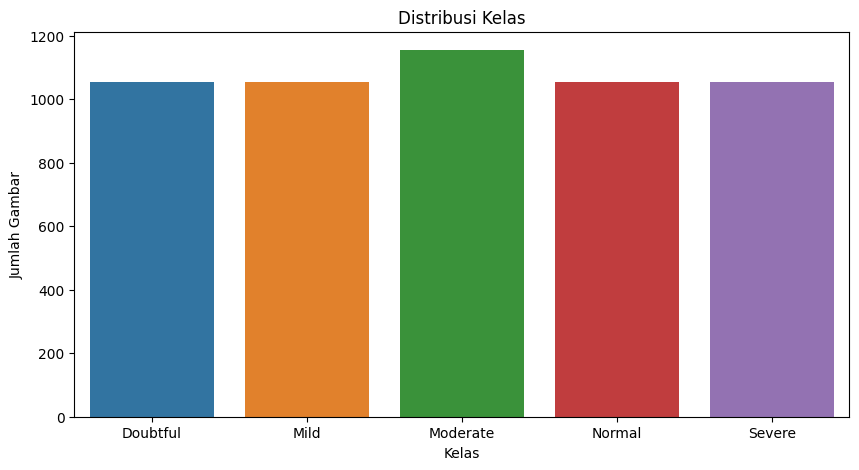

In [4]:
data_path = '/kaggle/input/dataset-2b/train'
classes = ['Doubtful', 'Mild', 'Moderate', 'Normal', 'Severe']

class_counts = {}
for cls in classes:
    data_dir = os.path.join(data_path, cls)
    class_counts[cls] = len(os.listdir(data_dir))

# Plot distribusi kelas
plt.figure(figsize=(10, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Distribusi Kelas')
plt.xlabel('Kelas')
plt.ylabel('Jumlah Gambar')
plt.show()

Dari distribusi pada data train, dapat dilihat bahwa jumlah gambar di setiap kelas seimbang, dengan yang paling banyak adalah kelas moderate dengan 1155 data dan sisanya 1055 data.

In [5]:
class_counts

{'Doubtful': 1055,
 'Mild': 1055,
 'Moderate': 1155,
 'Normal': 1055,
 'Severe': 1055}

In [6]:
data_test = "/kaggle/input/dataset-2b/test"

class_test_counts = {}
for cls in classes:
    data_dir = os.path.join(data_test, cls)
    class_test_counts[cls] = len(os.listdir(data_dir))

total_data = 0
for i in class_counts:
    total_data += class_counts[i]
    total_data += class_test_counts[i]
total_data

5961

Total dari seluruh data yakni 5961 data

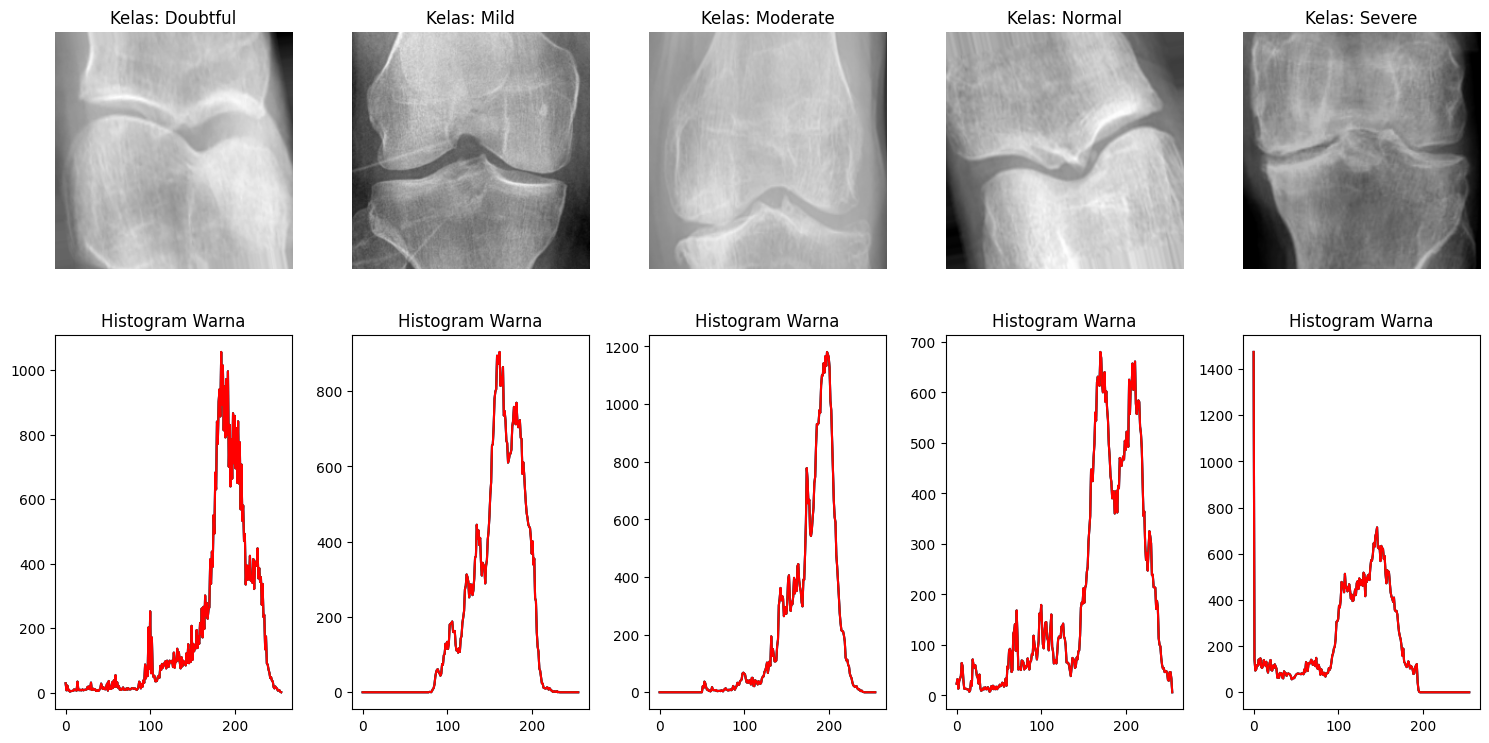

In [7]:
# Plot histogram warna per kelas
plt.figure(figsize=(15, 8))
for i, cls in enumerate(classes):
    img_path = os.path.join(data_path, cls, os.listdir(os.path.join(data_path, cls))[0])
    img = Image.open(img_path)
    
    # Plot gambar
    plt.subplot(2, 5, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f'Kelas: {cls}')
    plt.axis('off')
    
    # Plot histogram warna (RGB)
    plt.subplot(2, 5, i+6)
    img_array = np.array(img)
    img_array_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    for j, color in enumerate(['b', 'g', 'r']):
        hist = cv2.calcHist([img_array_bgr], [j], None, [256], [0, 256])
        plt.plot(hist, color=color)
    plt.title('Histogram Warna')

plt.tight_layout()
plt.show()


Histogram R, G, B hanya satu garis karena sebenarnya data gambar sudah digrayscale, tetapi tetap disimpan dalam format rgb, sehingga nilai r,g, dan b berhimpitan pada histogram.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


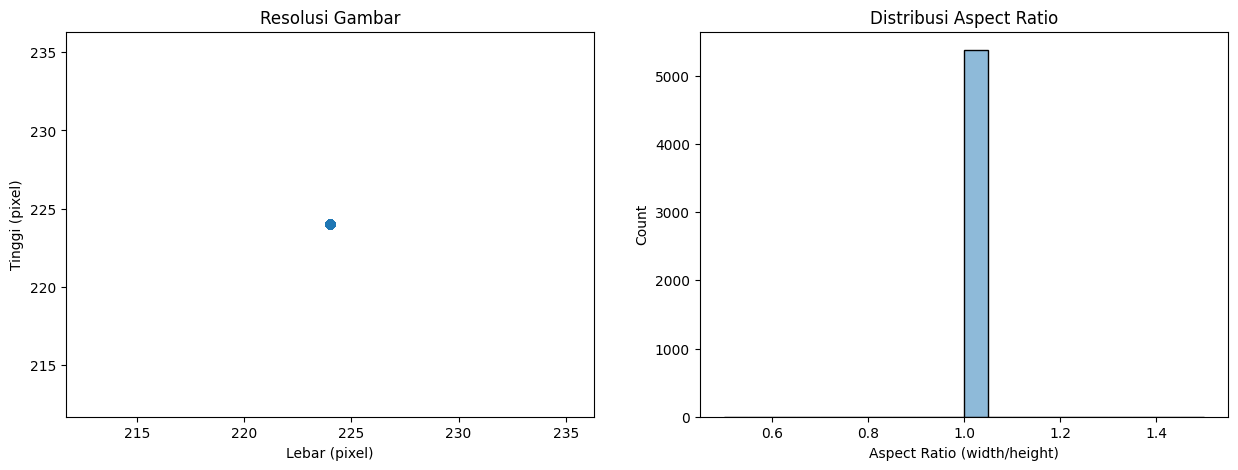

In [8]:
# Cek resolusi, aspect ratio, dan variasi
resolutions = []
aspect_ratios = []

for cls in classes:
    for img_file in os.listdir(os.path.join(data_path, cls)):
        img_path = os.path.join(data_path, cls, img_file)
        img = Image.open(img_path)
        width, height = img.size
        resolutions.append((width, height))
        aspect_ratios.append(width / height)

# Konversi ke array numpy
resolutions = np.array(resolutions)
aspect_ratios = np.array(aspect_ratios)

# Plot hasil
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.scatter(resolutions[:, 0], resolutions[:, 1], alpha=0.5)
plt.title('Resolusi Gambar')
plt.xlabel('Lebar (pixel)')
plt.ylabel('Tinggi (pixel)')

plt.subplot(1, 2, 2)
sns.histplot(aspect_ratios, bins=20, kde=True)
plt.title('Distribusi Aspect Ratio')
plt.xlabel('Aspect Ratio (width/height)')
plt.show()

Dapat dilihat dari scatterplot, bahwa semua data gambar beresolusi sama yakni 224 x 224 pixel  
Serta, semua aspek rasionya 1:1, tidak ada outlier pada data gambar

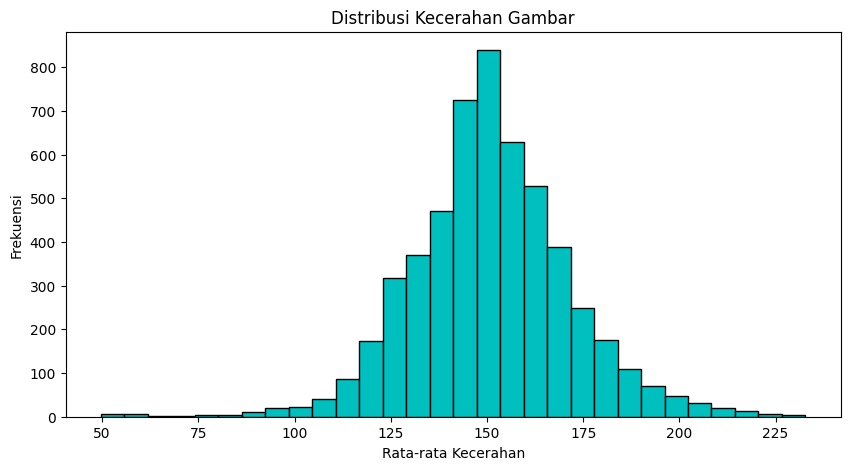

In [9]:
brightness = []

for cls in classes:
    class_dir = os.path.join(data_path, cls)
    for img_name in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_name)
        img = Image.open(img_path).convert('L')
        img_array = np.array(img)
        
        # Rata-rata brightness
        brightness.append(np.mean(img_array))

# Plot distribusi brightness
plt.figure(figsize=(10, 5))
plt.hist(brightness, bins=30, color='c', edgecolor='black')
plt.title('Distribusi Kecerahan Gambar')
plt.xlabel('Rata-rata Kecerahan')
plt.ylabel('Frekuensi')
plt.show()

Dalam skala kecerahan 0-255, mayoritas gambar berada di kecerahan menengah yakni 150. Dapat disimpulkan bahwa mayoritas gambar pada dataset train memiliki kecerahan yang moderat.

In [10]:
image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.15,
    horizontal_flip = True,
    zoom_range = 0.2,
    shear_range = 0.2,
    rotation_range = 15
)

val_datagen = ImageDataGenerator(
    rescale = 1./255,
    validation_split = 0.15
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    data_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training',
    seed = 42
)

val_generator = val_datagen.flow_from_directory(
    data_path,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation',
    seed = 42
)

test_generator = test_datagen.flow_from_directory(
    data_test,
    target_size = image_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    shuffle = False
)

Found 4570 images belonging to 5 classes.
Found 805 images belonging to 5 classes.
Found 586 images belonging to 5 classes.


15% dari data train akan diambil menjadi data validasi  
proses ini juga merupakan preprocessing, dimana akan dilakukan augmentasi pada data train berupa horizontal flip, zoom, shear, rotasi, dan rescale untuk menambah variasi dari data train selama proses training  
sementara itu, data validasi dan data testing tidak akan menerima augmentasi, hanya normalisasi berupa rescaling

In [11]:
train_files = set(train_generator.filenames)
val_files = set(val_generator.filenames)

# Check for overlap
overlap = train_files.intersection(val_files)
print(f"Jumlah overlapping files: {len(overlap)}")

Jumlah overlapping files: 0


Terbukti bahwa splitting data dengan validation_split terpisah pada train_datagen dan val_datagen tidak akan menghasilkan overlapping file

## B. Baseline Model

In [13]:
model = Sequential()

# Layer 1
model.add(Conv2D(96, kernel_size=(11,11), strides=4, activation='relu', input_shape=(224,224,3)))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

# Layer 2
model.add(Conv2D(256, kernel_size=(5,5), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

# Layer 3
model.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))

# Layer 4
model.add(Conv2D(384, kernel_size=(3,3), padding='same', activation='relu'))

# Layer 5
model.add(Conv2D(256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(3,3), strides=2))

# Flatten & Dense Layer
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))


Model di atas merupakan CNN dengan arsitektur AlexNet seperti di soal.  
Padding = 'same' digunakan karena dari convolution layer 2 dan seterusnya, conv layer tidak mengurangi dimensi output (input dan outputnya sama), yang mengurangi dimensi output yakni max pooling  

output layer menggunakan activation softmax karena target dari model merupakan multiclass classification, sehingga perlu menggunakan fungsi aktivasi. Saya memilih softmax karena softmax merupakan salah satu opsi yang umum digunakan untuk multiclass problem. (sigmoid untuk binary, linear untuk regresi)

In [14]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=[
                'accuracy',
                Precision(name='precision'),
                Recall(name='recall'),
                F1Score(name='f1_score')]
             )

Dicompile dengan optimizer adam dan mengukur loss dengan 'categorical_crossentropy', karena katanya bagus untuk kasus multiclass classification  

metrics yang nanti akan digunakan yakni accuracy, precision, recall, dan f1 score

In [15]:
callbacks = [
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    )
]

In [16]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks
)


Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 58s 390ms/step - accuracy: 0.2188 - f1_score: 0.1045 - loss: 1.6132 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2149 - val_f1_score: 0.0708 - val_loss: 1.6094 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 363ms/step - accuracy: 0.2136 - f1_score: 0.1183 - loss: 1.6101 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.1963 - val_f1_score: 0.0656 - val_loss: 1.6094 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 361ms/step - accuracy: 0.1976 - f1_score: 0.1148 - loss: 1.6097 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.2149 - val_f1_score: 0.0708 - val_loss: 1.6088 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 54s 355ms/step - accuracy: 0.2234 - f1_score: 0.0751 - loss: 1.6082 - preci

Melatih model dengan data train yang sudah digenerate saat preprocessing dan validasi dengan data validasi

In [17]:
model.save("alexnet.keras")


Untuk jaga jaga saya save dulu modelnya

In [16]:
model = keras.models.load_model('/kaggle/input/version-1/alexnet.keras')

Kernel error, jadi load dulu

## C. DenseNet Model

In [17]:
def dense_block(x, growth_rate, repetitions):
    for _ in range(repetitions):
        # Bottleneck layer
        y = BatchNormalization()(x)
        y = Conv2D(4 * growth_rate, (1,1), padding='same', activation='relu')(y)
        y = BatchNormalization()(y)
        y = Conv2D(growth_rate, (3,3), padding='same', activation='relu')(y)
        x = concatenate([x, y])
    return x

def transition_layer(x, reduction=0.5):
    channels = K.int_shape(x)[-1]
    x = BatchNormalization()(x)
    x = Conv2D(int(channels * reduction), (1,1), padding='same', activation='relu')(x)
    x = AvgPool2D((2,2), strides=2)(x)
    return x

# Input layer
inputs = Input(shape=(224,224,3))
x = Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = MaxPool2D((3,3), strides=2, padding = 'same')(x)

# Dense Blocks
x = dense_block(x, growth_rate=32, repetitions=6)
x = transition_layer(x)
x = dense_block(x, growth_rate=32, repetitions=12)
x = transition_layer(x)
x = dense_block(x, growth_rate=32, repetitions=24)
x = transition_layer(x)
x = dense_block(x, growth_rate=32, repetitions=16)

# Output
x = GlobalAveragePooling2D()(x)
outputs = Dense(5, activation='softmax')(x)
DenseNet_model = Model(inputs, outputs)

Saya menggunakan arsitektus DenseNet121  
- Ukuran filter dan jumlah layer sudah saya samakan dengan arsitektur DenseNet121
- repetisi pada dense block juga sama yakni 6,12,24,16
- Jumlah neuron bergantung pada growth rate, saya gunakan growth rate = 32 karena case di paper DenseNet121 juga menggunakan 32

In [18]:
DenseNet_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score')]
)

Optimizer dan pengukuran loss sama seperti model alexnet, yakni adam dan categorical crossentropy  
metrics juga sama, sesuai yang akan saya evaluasi nanti yaitu accuracy, precision, recall, dan f1 score

In [19]:
callbacks2 = [
    ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
]

untuk callback, saya gunakan checkpoint supaya bisa menyimpan last best model saat terjadi kegagalan training  
early stopping untuk menghentikan training ketika val_loss tidak membaik dalam 10 epoch (menghemat waktu)   
ReduceLROnPlateau untuk mengurangi learning rate menjadi 20% dari nilai learning rate saat ini. Hal ini terjadi ketika val_loss tidak membaik dalam 5 epoch (mencegah training yang stagnan)

In [22]:
history2 = DenseNet_model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks2
)

Epoch 1/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 90s 607ms/step - accuracy: 0.3607 - f1_score: 0.3555 - loss: 1.4355 - precision: 0.4276 - recall: 0.1878 - val_accuracy: 0.1876 - val_f1_score: 0.1021 - val_loss: 5.2840 - val_precision: 0.1883 - val_recall: 0.1764 - learning_rate: 0.0010
Epoch 2/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 62s 414ms/step - accuracy: 0.4442 - f1_score: 0.4425 - loss: 1.2822 - precision: 0.5373 - recall: 0.2628 - val_accuracy: 0.2137 - val_f1_score: 0.1247 - val_loss: 4.6719 - val_precision: 0.2229 - val_recall: 0.1913 - learning_rate: 0.0010
Epoch 3/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 399ms/step - accuracy: 0.4682 - f1_score: 0.4620 - loss: 1.1997 - precision: 0.5559 - recall: 0.3034 - val_accuracy: 0.2099 - val_f1_score: 0.1050 - val_loss: 4.5071 - val_precision: 0.2097 - val_recall: 0.2087 - learning_rate: 0.0010
Epoch 4/20
143/143 ━━━━━━━━━━━━━━━━━━━━ 60s 397ms/step - accuracy: 0.4957 - f1_score: 0.4932 - loss: 1.1569 - precision: 0.6006 - recall: 0.3371 - val_accuracy: 0.

Training model densenet

In [23]:
DenseNet_model.save('densenet_akhir.keras')

Saya save untuk jaga jaga

In [20]:
DenseNet_model = keras.models.load_model('/kaggle/input/version-1/densenet_akhir.keras')

Pada saat training, kernel disconnected sehingga saya langsung mengambil file model yang sebelumnya disimpan

In [22]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = DenseNet_model.evaluate(test_generator)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1_score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.4375 - f1_score: 0.3251 - loss: 1.1955 - precision: 0.4274 - recall: 0.2304
Test Loss: 0.9757485389709473
Test Accuracy: 0.5597269535064697
Test Precision: 0.6539509296417236
Test Recall: 0.4095562994480133
Test F1 Score: [0.37190077 0.4081632  0.6475409  0.4552845  0.88524586]


Hasil metrics dari densenet model sebelum dituning

#### Hyperparameter tuning pada DenseNet

In [23]:
def build_model(hp):
    # Hyperparameter yang akan di-tuning
    growth_rate = hp.Choice('growth_rate', [32, 48])
    learning_rate = hp.Choice('learning_rate', [1e-3, 3e-4, 1e-4])
    
    # Pilihan untuk jumlah layer (repetitions) di setiap dense block
    block1_repeats = hp.Int('block1_repeats', min_value=4, max_value=8, step=2) 
    block2_repeats = hp.Int('block2_repeats', min_value=10, max_value=14, step=2)
    block3_repeats = hp.Int('block3_repeats', min_value=20, max_value=28, step=4)
    block4_repeats = hp.Int('block4_repeats', min_value=12, max_value=20, step=4)

    # Input layer (tetap sama)
    inputs = layers.Input(shape=(224, 224, 3))
    x = layers.Conv2D(64, (7,7), strides=2, padding='same', activation='relu')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPool2D((3,3), strides=2, padding='same')(x)

    # Dense Blocks dengan hyperparameter
    x = dense_block(x, growth_rate=growth_rate, repetitions=block1_repeats)
    x = transition_layer(x)
    x = dense_block(x, growth_rate=growth_rate, repetitions=block2_repeats)
    x = transition_layer(x)
    x = dense_block(x, growth_rate=growth_rate, repetitions=block3_repeats)
    x = transition_layer(x)
    x = dense_block(x, growth_rate=growth_rate, repetitions=block4_repeats)

    # Output
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(5, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    
    # Compile dengan learning rate yang di-tuning
    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='categorical_crossentropy',
        metrics=[
        'accuracy',
        Precision(name='precision'),
        Recall(name='recall'),
        F1Score(name='f1_score')]
    )
    return model

Saya melakukan tuning pada beberapa hyperparameter seperti:
- nilai growth rate (mempengaruhi jumlah neuron) : 32, 48
- learning rate: 1e-3, 3e-4, 1e-4
- nilai repetisi pada dense block (bervariasi tergantung denseblock)

In [24]:
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='densenet_tuning',
    project_name='densenet_hyperparams'
)

menggunakan keras_tuner untuk menjalankan randomsearch (sehingga tidak semua kemungkinan dicoba pada hyperparameter tuning)

In [27]:
# Callback untuk menghentikan training jika tidak membaik
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Mulai tuning
tuner.search(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[stop_early]
)

Trial 10 Complete [00h 13m 08s]
val_accuracy: 0.20993788540363312

Best val_accuracy So Far: 0.2844720482826233
Total elapsed time: 01h 55m 52s


In [ ]:
# Dapatkan hyperparameter terbaik
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal hyperparameters:
- Growth rate: {best_hps.get('growth_rate')}
- Learning rate: {best_hps.get('learning_rate')}
- Block 1 repeats: {best_hps.get('block1_repeats')}
- Block 2 repeats: {best_hps.get('block2_repeats')}
- Block 3 repeats: {best_hps.get('block3_repeats')}
- Block 4 repeats: {best_hps.get('block4_repeats')}
""")


best_DenseNet = tuner.hypermodel.build(best_hps)
history3 = best_DenseNet.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=val_generator,
    callbacks=callbacks2
)


Optimal hyperparameters:
- Growth rate: 48
- Learning rate: 0.001
- Block 1 repeats: 8
- Block 2 repeats: 10
- Block 3 repeats: 28
- Block 4 repeats: 16

Epoch 1/20


Optimal hyperparameters:
- Growth rate: 48
- Learning rate: 0.001
- Block 1 repeats: 8
- Block 2 repeats: 10
- Block 3 repeats: 28
- Block 4 repeats: 16

In [ ]:
best_hps = {
    'growth_rate': 48,
    'learning_rate': 0.001,
    'block1_repeats': 8,
    'block2_repeats': 10,
    'block3_repeats': 28,
    'block4_repeats': 16
}

reconstructed_hps = HyperParameters()
reconstructed_hps.Fixed('growth_rate', best_hps['growth_rate'])
reconstructed_hps.Fixed('learning_rate', best_hps['learning_rate'])
reconstructed_hps.Fixed('block1_repeats', best_hps['block1_repeats'])
reconstructed_hps.Fixed('block2_repeats', best_hps['block2_repeats'])
reconstructed_hps.Fixed('block3_repeats', best_hps['block3_repeats'])
reconstructed_hps.Fixed('block4_repeats', best_hps['block4_repeats'])

best_DenseNet = tuner.hypermodel.build(reconstructed_hps)
history3 = best_DenseNet.fit(
    train_generator,
    epochs=20,
    batch_size=32,
    validation_data=val_generator,
    callbacks=callbacks2
)

error setelah hyperparameter tuning, sehingga saya rekonstruksi best parameternya, tetapi lama untuk dijalankan

In [30]:
def build_model(best_hps):
    # Input layer
    inputs = Input(shape=(224, 224, 3))
    x = Conv2D(64, (7, 7), strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = MaxPool2D((3, 3), strides=2, padding='same')(x)

    # Dense Blocks using the hyperparameters from best_hps
    x = dense_block(x, growth_rate=best_hps['growth_rate'], repetitions=best_hps['block1_repeats'])
    x = transition_layer(x)
    x = dense_block(x, growth_rate=best_hps['growth_rate'], repetitions=best_hps['block2_repeats'])
    x = transition_layer(x)
    x = dense_block(x, growth_rate=best_hps['growth_rate'], repetitions=best_hps['block3_repeats'])
    x = transition_layer(x)
    x = dense_block(x, growth_rate=best_hps['growth_rate'], repetitions=best_hps['block4_repeats'])

    # Output layer
    x = GlobalAveragePooling2D()(x)
    outputs = Dense(5, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(learning_rate=best_hps['learning_rate']),
                  loss='categorical_crossentropy',
                  metrics=[
                        'accuracy',
                        Precision(name='precision'),
                        Recall(name='recall'),
                        F1Score(name='f1_score')])
    
    return model

In [31]:
best_DenseNet = build_model(best_hps)

In [ ]:
history3 = best_DenseNet.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=callbacks2
)

In [ ]:
best_DenseNet.save('best_densenet.keras')

Model hasil hyperparameter tuning sangat lama untuk ditrain (tidak muncul proses epoch), sepertinya stuck  
Saya mohon izin untuk membandingkan baseline model dengan denseNet model sebelum dituning

In [40]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = model.evaluate(test_generator)

print(f"AlexNet Loss: {test_loss}")
print(f"AlexNet Accuracy: {test_accuracy}")
print(f"AlexNet Precision: {test_precision}")
print(f"AlexNet Recall: {test_recall}")
print(f"AlexNet F1 Score: {test_f1_score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.1506 - f1_score: 0.0484 - loss: 1.6146 - precision: 0.0000e+00 - recall: 0.0000e+00
AlexNet Loss: 1.6100565195083618
AlexNet Accuracy: 0.19965870678424835
AlexNet Precision: 0.0
AlexNet Recall: 0.0
AlexNet F1 Score: [0.         0.         0.33285913 0.         0.        ]


In [41]:
test_loss, test_accuracy, test_precision, test_recall, test_f1_score = DenseNet_model.evaluate(test_generator)

print(f"DenseNet Loss: {test_loss}")
print(f"DenseNet Accuracy: {test_accuracy}")
print(f"DenseNet Precision: {test_precision}")
print(f"DenseNet Recall: {test_recall}")
print(f"DenseNet F1 Score: {test_f1_score}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step - accuracy: 0.4375 - f1_score: 0.3251 - loss: 1.1955 - precision: 0.4274 - recall: 0.2304
DenseNet Loss: 0.9757485389709473
DenseNet Accuracy: 0.5597269535064697
DenseNet Precision: 0.6539509296417236
DenseNet Recall: 0.4095562994480133
DenseNet F1 Score: [0.37190077 0.4081632  0.6475409  0.4552845  0.88524586]


Performa pada DenseNet jauh lebih optimal mulai dari accuracy, precision, hingga f1 score  
Pada DenseNet:
- Accuracy 55.9% artinya 55% prediksi model merupakan prediksi yang akurat
- Precision 65%, artinya 65% dari prediksi positif model merupakan prediksi yang tepat
- recall 40.9%, artinya 40% dari data actual positif berhasil diprediksi positif oleh model
- dan f1 score menunjukkan keseimbangan antara precision dan recall pada 5 class yang tersedia

Bisa dikatakan DenseNet memiliki performa jauh lebih baik dari AlexNet, tetapi performa model ini belum dapat dikatakan cukup baik untuk deployment karena untuk data medis, kita mengharapkan recall score di atas 90% supaya data yang seharusnya positif di suatu class berhasil diprediksi positif (menghindari false negatif atau kegagalan deteksi)